# <u> Breast Tumour Type Data Analysis and Predictive Modelling <u>

This notebook analyses the data from the [Wisconsin Breast Cancer](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) data set. We wish to develop insight into the most important features in predicting whether a particular tumor is Benignin or Malignant based upon 30 features recorded from 569 patients.

We draw insights into the relationship between features through multivariate analysis. Moreoever, we use  PCA to project our data to 2D whilst mainting a suitable threshold of variance present in the data. We then explore the use of supervised learning algorithms: $L_{1}$ regularised Logistic Regression, ElasticNet Logistic Regression, Support Vector Machines and Random Forest. We compare the performance of algorithms with performance metrics and AUC.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import boxcox
from scipy.cluster import hierarchy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, fbeta_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier

# <u> Data Origins and Pre-processing <u>

In [2]:
data = pd.read_csv("tumour_data.csv")
data = data.drop(['id', 'Unnamed: 32'], axis=1)

In [3]:
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

The above list contains all features and our target variable (diagnosis). These features are computed from digitised image of a Fine Needle Aspiration (FNA) of the Breast (See [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) for more information). We will analyse the relative feature importance in determining tumour type based upon the data set. We first map the string values to numeric values that can be understood by binary classifiers. 

In [4]:
dic = {'M': 1, 'B': 0}
data['diagnosis'] = data['diagnosis'].map(dic)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We would like to be sure our data is suitably pre-processed. First, we ensure there are no null values.

In [5]:
if data.isnull().sum().any() > 0:
    print ('Missing value present.')
else:
    print ('No missing values.')

No missing values.


## <u> Exploratory Data Analysis <u>

We are now in a position to perform an exploratory data analysis of our features. Firstly, we consider the instance of each class in our data set and check of an imbalance.

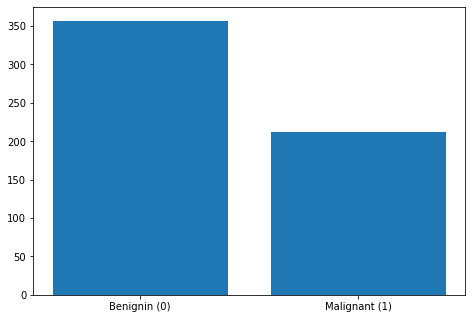

In [6]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
tumour_type = ['Benignin (0)', 'Malignant (1)']
count = [len(data['diagnosis']) - sum(data['diagnosis']), sum(data['diagnosis'])]
ax.bar(tumour_type, count)
plt.show()

Although there is a slight imbalance, it is no cause for concern. We are still able to use accuracy as a suitable performance metric for our classifiers on our test set. We must appreciate the relative importance weightings of Type I (False Positive) and Type II (False Negative) errors in the context of this task. This is discussed later.

We now consider their pairwise correlations to detect any collinearity between our features. Typically it will be a good idea to remove features that are highly correlated together. We decide upon features to remove based on pairwise linear correlations and then fit a logistic regression model. We will later use regularisation to solve this problem directly. 

One should note that the correlation matrix will only consider linear correlations (Pearson Correlation), the features could be related in a non-linear manner. In order for inference on individual features to be made, we must remove linearly correlated features.

In [7]:
corr = data.corr().round(2)
corr

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.00,0.73,0.42,0.74,0.71,0.36,0.60,0.70,0.78,0.33,...,0.78,0.46,0.78,0.73,0.42,0.59,0.66,0.79,0.42,0.32
radius_mean,0.73,1.00,0.32,1.00,0.99,0.17,0.51,0.68,0.82,0.15,...,0.97,0.30,0.97,0.94,0.12,0.41,0.53,0.74,0.16,0.01
texture_mean,0.42,0.32,1.00,0.33,0.32,-0.02,0.24,0.30,0.29,0.07,...,0.35,0.91,0.36,0.34,0.08,0.28,0.30,0.30,0.11,0.12
perimeter_mean,0.74,1.00,0.33,1.00,0.99,0.21,0.56,0.72,0.85,0.18,...,0.97,0.30,0.97,0.94,0.15,0.46,0.56,0.77,0.19,0.05
area_mean,0.71,0.99,0.32,0.99,1.00,0.18,0.50,0.69,0.82,0.15,...,0.96,0.29,0.96,0.96,0.12,0.39,0.51,0.72,0.14,0.00
smoothness_mean,0.36,0.17,-0.02,0.21,0.18,1.00,0.66,0.52,0.55,0.56,...,0.21,0.04,0.24,0.21,0.81,0.47,0.43,0.50,0.39,0.50
compactness_mean,0.60,0.51,0.24,0.56,0.50,0.66,1.00,0.88,0.83,0.60,...,0.54,0.25,0.59,0.51,0.57,0.87,0.82,0.82,0.51,0.69
concavity_mean,0.70,0.68,0.30,0.72,0.69,0.52,0.88,1.00,0.92,0.50,...,0.69,0.30,0.73,0.68,0.45,0.75,0.88,0.86,0.41,0.51
concave points_mean,0.78,0.82,0.29,0.85,0.82,0.55,0.83,0.92,1.00,0.46,...,0.83,0.29,0.86,0.81,0.45,0.67,0.75,0.91,0.38,0.37
symmetry_mean,0.33,0.15,0.07,0.18,0.15,0.56,0.60,0.50,0.46,1.00,...,0.19,0.09,0.22,0.18,0.43,0.47,0.43,0.43,0.70,0.44


Based solely on an the feaure descriptions and how they are constructed, it is clear that there is to be expected some strong linear and quadratic relationships between certain features. Assuming circularity of all tumours, (Perimeter, Radius) are exactly linearly related since $P=2\pi r$. Moreover, (Area, Radius) and (Area, Perimeter) are exactly quadratiaclly related as $A=2\pi r^2$ and $A = \frac{P^2}{2\pi}$. We also notice that this is an extended data set, containing _worst and _se parameters for each of the original _mean parameters. There is expected to be some slight linear correlation between these variables. This is demonstrated in their pairwise scatter plots.

<Figure size 2160x2160 with 0 Axes>

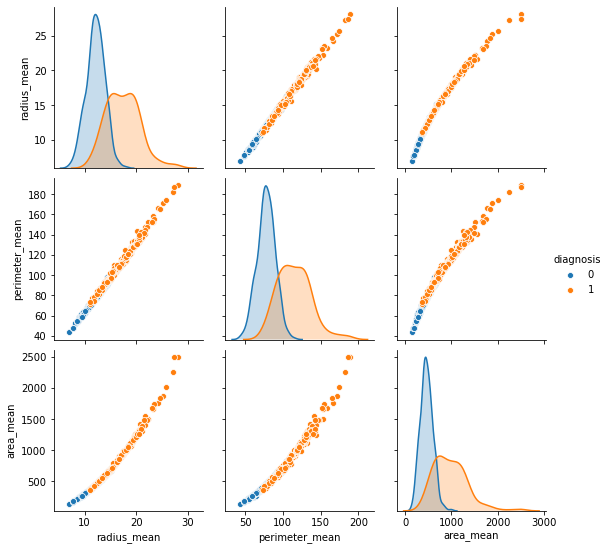

In [8]:
mean_features = ['diagnosis','radius_mean', 'perimeter_mean','area_mean']

mean_features_data = data[mean_features]

plt.figure(figsize=(30,30)) 
sb.pairplot(data=mean_features_data, hue='diagnosis')
plt.show()

The problem of collinearity of features will not be a problem for the prediction task. However, it will case problems for understanding individual feature signficance using the Generalised Linear Model formulation of logistic regression. Hence, we drop one of each related feature for this analysis and model fitting. 

From the scatter plot we see how the tumours that are classified as Malignant (1) typically have larger measurements in area, radius and perimeter. 

## <u> Outlier Detection <u>

We note that there appear to be observations with much larger Standard Error (se).

<Figure size 2160x2160 with 0 Axes>

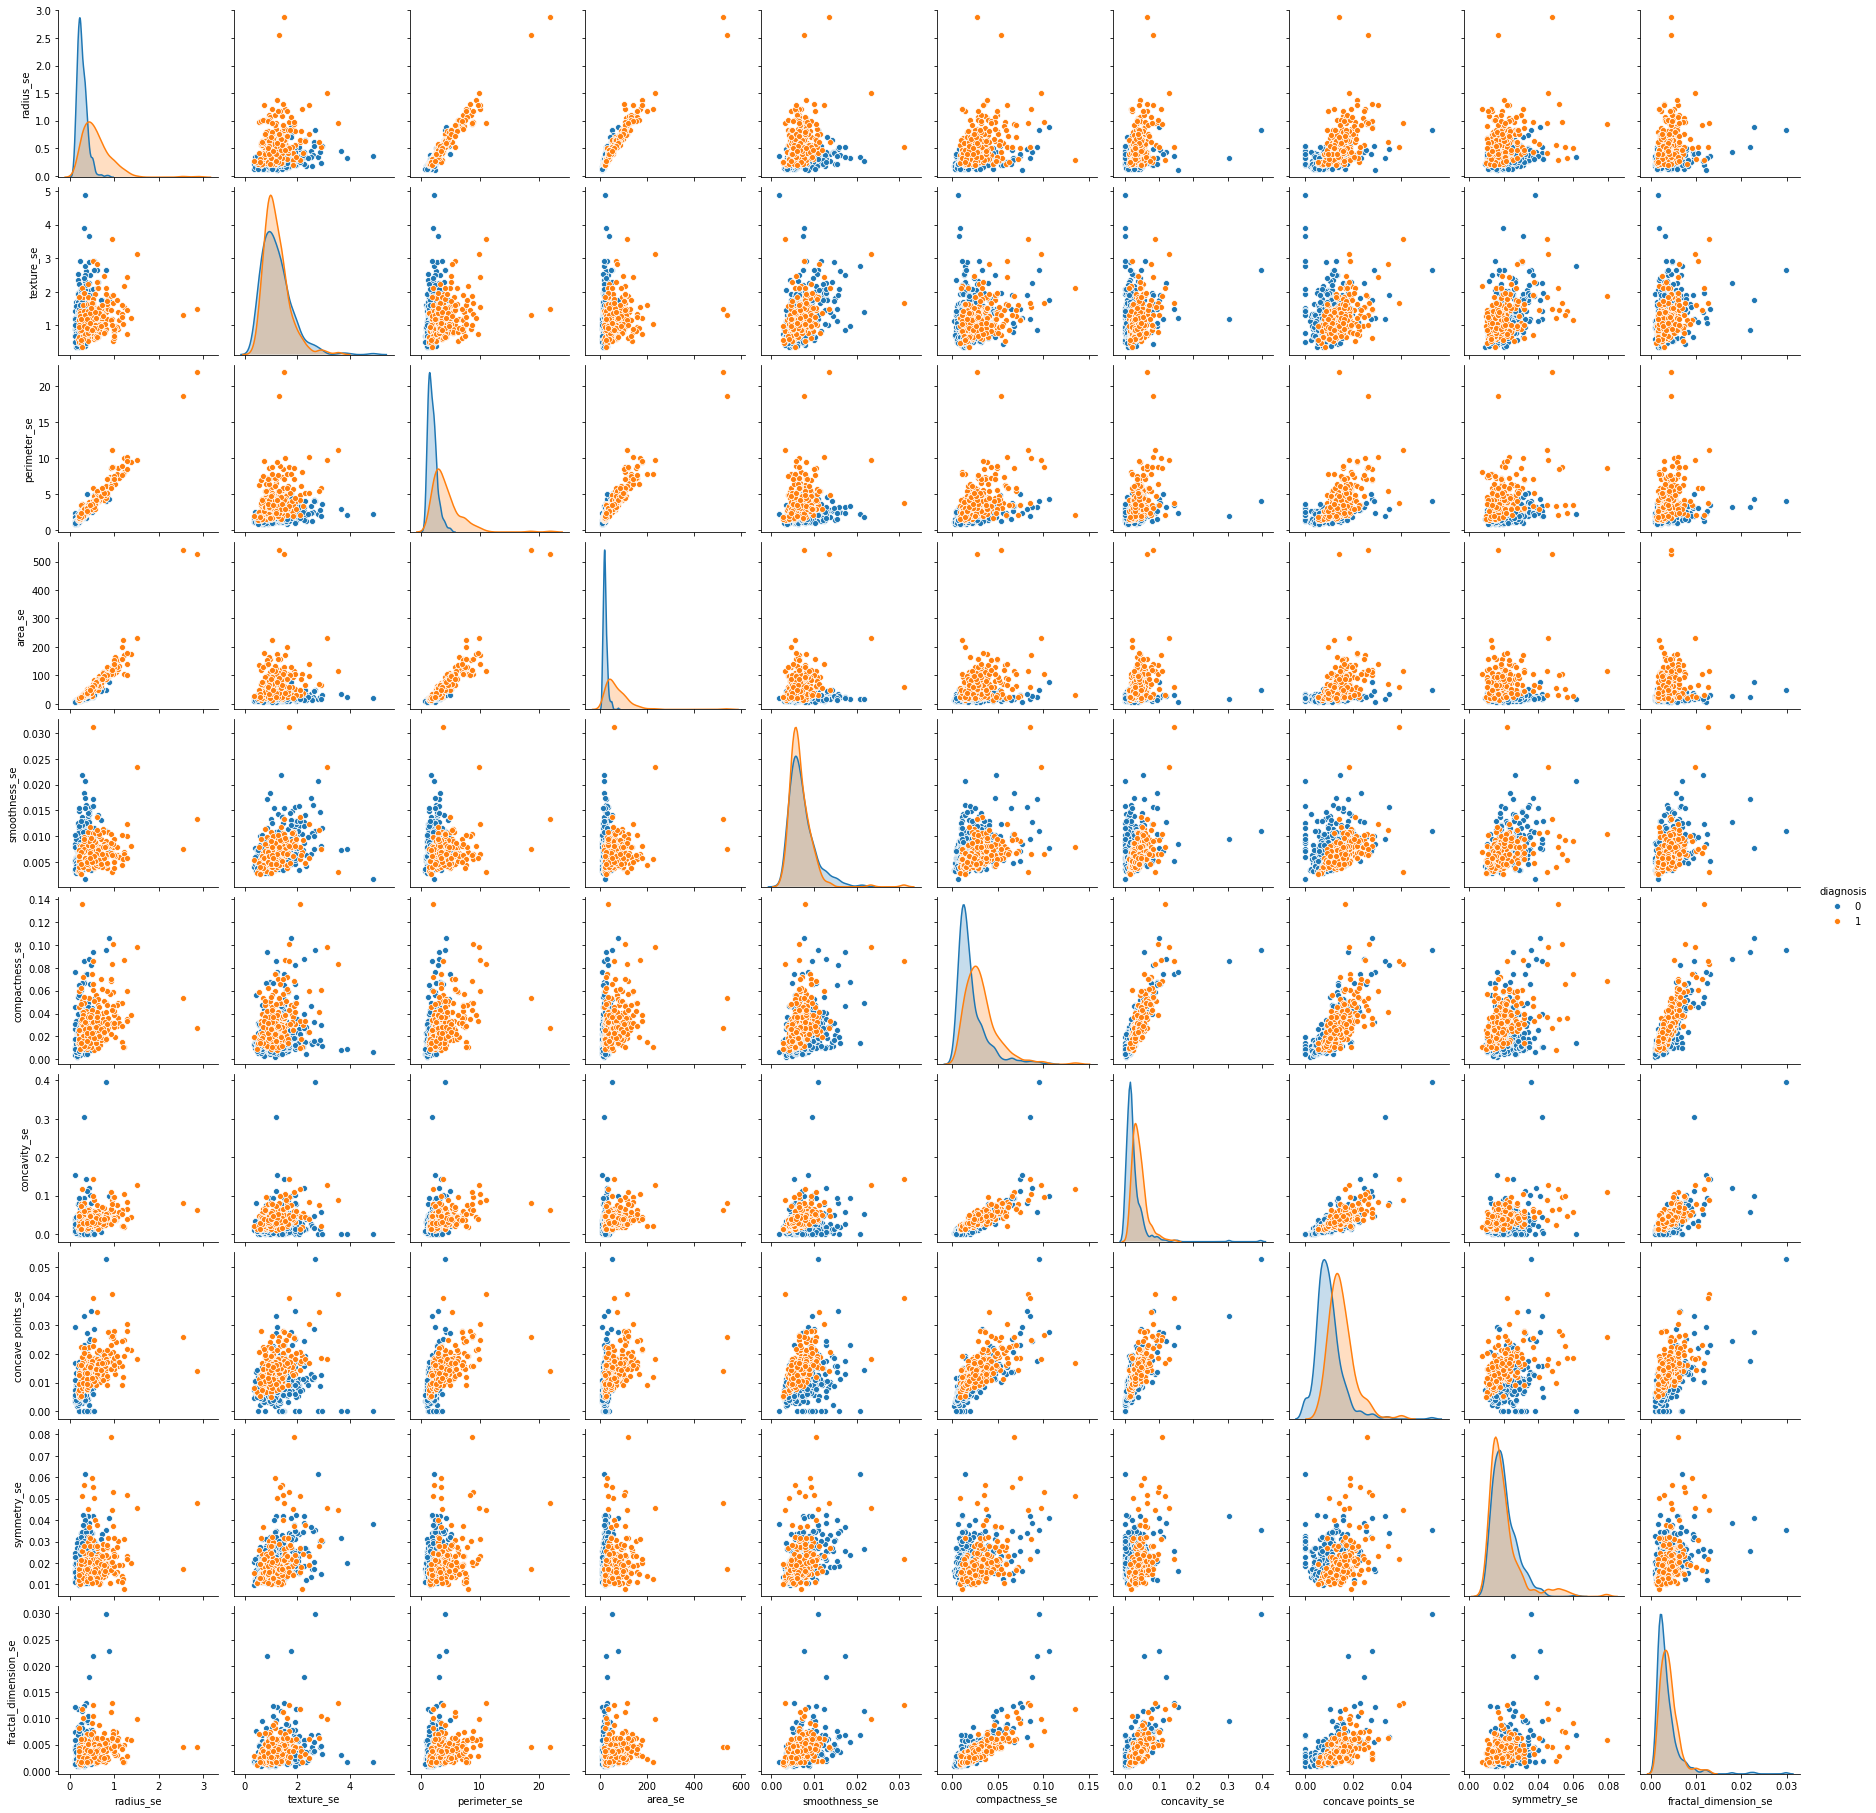

In [9]:
se_features = ['diagnosis','radius_se', 'texture_se', 'perimeter_se',
       'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
       'concave points_se', 'symmetry_se', 'fractal_dimension_se']

se_features_data = data[se_features]

plt.figure(figsize=(30,30)) 
sb.pairplot(data=se_features_data, hue='diagnosis')
plt.show()

Outliers are tricky, we should not be so hasty to remove them. In fact, based upon the skewed nature of '_se' features, we decide to perform a box cox transformation to normalsie the data without removing the outliers. 

In [10]:
box_cox_data = data.copy()
box_cox_features = ['radius_se', 'texture_se', 'perimeter_se',
       'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
       'concave points_se', 'symmetry_se', 'fractal_dimension_se']

box_cox_data[box_cox_features].describe()
box_cox_data = box_cox_data[box_cox_data['concavity_se'] != 0]

for feature in box_cox_features:
    box_cox_data[feature] =  boxcox(box_cox_data[feature])[0]


In [11]:
plt.figure(figsize=(30,30)) 
#sb.pairplot(data=box_cox_data[se_features], hue='diagnosis')
#plt.show()

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

Not so bad anymore. We create a new data set with the 'outlier' removed for comparison.

In [12]:
data_clean  = data[~(data['radius_se'] > 2)]

## <u>Data Visualisation with Dimensionality Reduction <u>

We first perform our train test split to ensure we are able to gain insight into the generalisation error of our classifiers  by using our test set. We also standardise and center our test and training data separately. 

In [13]:
Y = box_cox_data['diagnosis']
X = box_cox_data.loc[:, box_cox_data.columns != 'diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 1)

In [14]:
X_train_standard = (X_train - X_train.mean())/X_train.std()
X_test_standard = (X_test - X_test.mean())/X_test.std()

We notice from before that there are quite a number of linearly correlated variables. We take two approaches, the first is to utilise the unsupervised technique PCA and analyse our data in lower dimensions under an orthogonal basis. 

This will reduce the dimension of our data while and allow for easier visualisation. Moreover, we gain insight into the relative variability of features using the Principal Components. PCA uses the size of eigenvalues of the sample correlation matrix and it's corresponding eigenvectors to create a new orthogonal basis upon which our higher dimensional data can be projected. We are then able to visualise our data in 2D by plotting pairwise principal components.

Let us analyse the amount of variance explained as we increase the number of principal components considered with a Scree plot. 

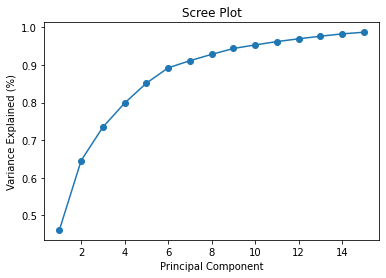

In [15]:
linear_pca = PCA(n_components = 15)
linear_pca_fit = linear_pca.fit(X_train_standard)
linear_pca_fit.explained_variance_ratio_
PC_values = np.arange(linear_pca_fit.n_components_) + 1
plt.plot(PC_values, np.cumsum(linear_pca_fit.explained_variance_ratio_), 'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.show()

We project our data onto the first and second principal components and visualise.  

In [16]:
transformed_data = linear_pca_fit.fit_transform(X_train_standard)

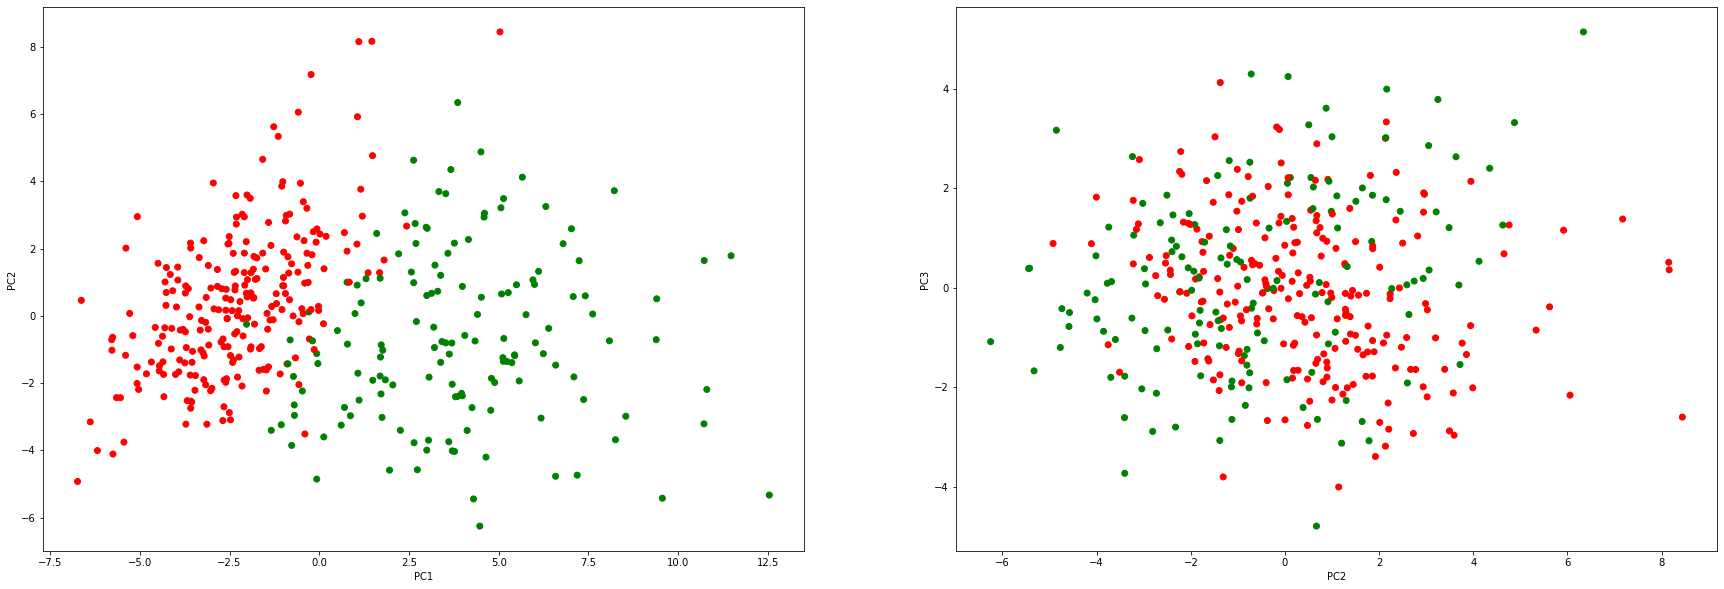

In [17]:
colormap = np.array(['r', 'g'])
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.scatter(transformed_data[:,0], transformed_data[:,1], c=colormap[y_train])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.subplot(122)
plt.scatter(transformed_data[:,1], transformed_data[:,2], c=colormap[y_train])
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.show()

The sample variance matrix, $S = \frac{X^{T}X}{n-1}$, contains correlation data between variables. These eigenvector corresponding to our the largest eigenvalue is the direction of the first principle component and so on. 

## <u> Feature Significance Analysis with Generalised Linear Model <u>

We first introduce Logistic Regression as an instance of a Generalised Linear Model to gain insight into significant features on the original 10 feature data set. We asssume a Binomial (Bernoulli) response with a logit link function mapping our mean response to our linear predictors. Let $Y_{i} \sim_{i.n.d} \text{Binomial}(1,\pi_{i})$ for $i \in \{1, \cdots, n\}$ denote the response variable of the $i$th observation. Moreover, let $\mathbf{x}_{i}$ denote the corresponding features as a column vector. Then, for a column vector of parameters $\beta_{0}$, we model the distribution of the response as,

$$\mathbb{P}(Y_{i} = 1| \mathbf{x}_{i}; \beta_{0}) = \pi_{i} = \frac{\exp{\mathbf{x}_{i}^{T}\mathbf{\beta}_{0}}}{1+\exp{\mathbf{x}_{i}^{T}\mathbf{\beta}_{0}}}$$

Let us fit a logistic regression model to the non-standardised original mean feature data set with one of each pariwise linearly correlated features removed. We have 7 parameter estimates, 6 features and 1 incercept. 

In [18]:
log_reg_data = data[['diagnosis',  'texture_mean' , 'smoothness_mean' , 'symmetry_mean' , 'fractal_dimension_mean', 'area_mean', 
                     'concavity_mean']]

log_reg_model = 'diagnosis ~  texture_mean + smoothness_mean + symmetry_mean + fractal_dimension_mean + area_mean + concavity_mean'
log_reg_model_fit = smf.glm(log_reg_model, family = sm.families.Binomial(), data=log_reg_data).fit()
log_reg_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              diagnosis   No. Observations:                  569
Model:                            GLM   Df Residuals:                      562
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -76.776
Date:                Mon, 21 Nov 2022   Deviance:                       153.55
Time:                        12:47:47   Pearson chi2:                     386.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -27.6774      5.021     -5.512      0.000     -37.519     -17.835
texture_mean               0.3854      0.063      6.125      0.000       0.262       0.509
smoothness_mean          124.3260     25.155      4.942      0.000      75.022     173.630
symmetry_mean             16.0259     10.877      1.473      0.141      -5.293      37.345
fractal_dimension_mean   -97.6267     60.465     -1.615      0.106    -216.136      20.883
area_mean                  0.0137      0.002      6.241      0.000       0.009       0.018
concavity_mean            23.8298      5.769      4.131      0.000      12.523      35.137
==========================================================================================
"""

The 4th column produces a p-value based upon a Wald Test. This test is based upon Maximum Liklihood Estimation theory and utilises the multivariate Central Limit Theorem. The test utilises asympototic assumptions about the distribution of our optimal parameter estimates. Wald hypothesis tests are performed to test the null hypothesis that the parameter is 0. 

All features apart from 'fractal_dimension_mean' and 'symmetry_mean' have significant p values. Hence, we reject the null hypothesis that they are 0. 

We now assess the influence of each observation on the model fit using leverage and standardised residuals. 

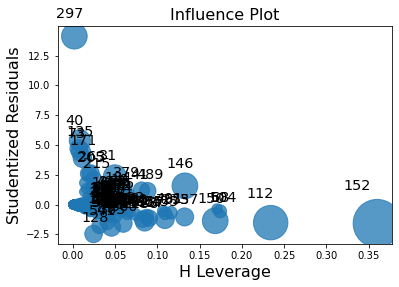

In [19]:
infl = log_reg_model_fit.get_influence(observed=False)
fig = infl.plot_influence()
plt.show()

In [20]:
summ_df = infl.summary_frame()
summ_df.sort_values("cooks_d", ascending=False)[:10]

,dfb_Intercept,dfb_texture_mean,dfb_smoothness_mean,dfb_symmetry_mean,dfb_fractal_dimension_mean,dfb_area_mean,dfb_concavity_mean,cooks_d,standard_resid,hat_diag,dffits_internal
152,-0.153200,0.138164,0.342847,-0.158820,-0.006496,0.262476,-0.610853,0.200988,-1.581827,0.359908,-1.186134
112,-0.074222,0.061526,0.319650,0.217267,-0.196626,-0.029373,-0.355756,0.100494,-1.517516,0.233994,-0.838725
146,-0.004379,-0.074292,-0.214543,0.508372,-0.048747,-0.114318,0.012744,0.053737,1.568749,0.132584,0.613317
150,0.121073,-0.132857,-0.060063,-0.518785,0.173495,0.000176,0.098249,0.053520,-1.360072,0.168419,-0.612076
297,0.348331,-0.373783,-0.176704,-0.247686,0.089590,-0.394280,-0.240565,0.053190,14.117150,0.001865,0.610189
31,-0.225587,-0.038589,-0.217019,0.216231,0.366847,0.056035,-0.299201,0.041954,2.367451,0.049789,0.541921
40,0.296258,-0.183557,-0.321749,0.155268,-0.077514,-0.281774,-0.109169,0.034737,5.380252,0.008330,0.493110
73,0.141252,-0.295948,-0.105342,-0.243736,0.171604,-0.096386,-0.147929,0.027300,4.423197,0.009673,0.437153
238,-0.007676,-0.195852,-0.042502,0.252962,-0.009182,-0.023445,-0.155309,0.026936,-1.424762,0.084992,-0.434228
455,0.117263,-0.276758,-0.136152,0.200663,-0.069377,-0.062536,0.038394,0.026153,-1.224134,0.108870,-0.427871


It appears that no observation has a large enough influence on the model fit, based upon Cooks Distances (All are less than 0.5), to warrant removal for this model. 

## <u> Feature Shrinkage and Classification with L1 Regularised Logistic Regression <u>

Logistic regression can be fit as a classifier. Recall the estimtion problem encountered in the previous section. Let $\mathbf{x}^{*}$ be an element of the training data. Then, with our estimated parameters that are based on the training data, we predict the class of $\mathbf{x}^{*}$, denoted $Y^{*}$ based on the following classification rule,

$$Y^{*} = 1, \ \ \text{if} \ \ \pi^{*} > 0.5$$
$$Y^{*} = 0, \ \ \text{if} \ \ \pi^{*} < 0.5$$


Due to the high number of features on our dataset, we would like to gain insight into which features are potentially redundant. This can be achieved by adding an $L_{1}$ penalty term when minimising the parameter likelihood function. Doing so introduces another hyperparameter $C$ that controls the strength of reguliarisation (Smaller values lead to greater regularisation and hence more parameters are shrunk to 0). The regularisation term will also ensure we are not overfitting our training data, in principle reducing our generalisation error. This also reduces the need for decorrelating features and automatically provides feature selection, thus we include all features of our standardised training data in training our classifier.  We tune the hyperparemeter $C$ with a 5-Fold Cross Validation.

In [21]:
C_parameters = [0.01, 1, 100]
LASSO_log_reg_clf_tuned = LogisticRegressionCV(Cs = C_parameters, cv = 5, penalty = 'l1', solver = 'liblinear', fit_intercept = True)
LASSO_log_reg_clf_tuned.fit(X_train_standard, y_train)

print('Optimal C:', LASSO_log_reg_clf_tuned.C_)
print('Coefficients:', LASSO_log_reg_clf_tuned.coef_)
print('Intercept:', LASSO_log_reg_clf_tuned.intercept_)
print('Training accuracy:', LASSO_log_reg_clf_tuned.score(X_train_standard, y_train))
print('Test accuracy:', LASSO_log_reg_clf_tuned.score(X_test_standard, y_test))

Optimal C: [100.]
Coefficients: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -7.03523745e+00  0.00000000e+00  0.00000000e+00  3.07810034e+01
  -3.45547459e+00 -9.02505937e+00  3.91985644e+00 -1.12187474e+00
  -1.40404648e+00  1.14049981e+01  2.69313846e+00 -1.20967872e+01
   1.24130537e+01 -1.65566036e-01 -7.57795995e+00 -2.11371226e+00
   8.98741920e-03  7.94626348e+00  5.15213905e+00  0.00000000e+00
   5.71315290e+00  0.00000000e+00 -6.72897658e+00  1.25417347e+00
   9.92360750e+00  1.29865880e+01]]
Intercept: [-2.62630928]
Training accuracy: 1.0
Test accuracy: 0.9640718562874252


In [22]:
regularised_features_num = np.where(LASSO_log_reg_clf_tuned.coef_[0] != 0)[0]
X_train_standard.columns[regularised_features_num]

Index(['smoothness_mean', 'concave points_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se',
       'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
       'concave points_se', 'symmetry_se', 'fractal_dimension_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'smoothness_worst',
       'concavity_worst', 'concave points_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')

We see that the regularised regression model has shrunk parameters of certain features in the full data set to 0. We are left with the above list of parameters involved in the regression problem. Moreover, we see the influence this has upon the test set accuracy. The model is not overfitting the training data and hence performing well on unseen test set with low generalisation error. 

In [23]:
y_pred = LASSO_log_reg_clf_tuned.predict(X_test_standard)
confusion_matrix(y_test, y_pred)

array([[97,  3],
       [ 3, 64]], dtype=int64)

In [24]:
roc_auc_score(y_test, y_pred)

0.9626119402985074

In the context of this task, we really do not want to be making false negatives (Type II errors). Misdiagnosing a Malignant tumour as Benignin would mean that the patient would not seek further treatment and the cancer would metastasise after going undetected by our model. In order to modify this, we can change our threshold probability in our classification rule from 0.5 to much lower probability. Of course, doing so would lead to more false positives (Type I errors). Let us make a custom classification rule with our regularised logistic regression parameters and use a lower threshold probability.

In [25]:
beta_int = LASSO_log_reg_clf_tuned.intercept_
beta_coef = LASSO_log_reg_clf_tuned.coef_

def L1_logistic_reg_classifier(x, p):
    if (np.exp( beta_int[0] + np.dot(beta_coef[0], x)))/( 1 + np.exp(beta_int[0] + np.dot(beta_coef[0], x))) > p:
        return 1
    else:
        return 0
    
y_pred = X_test_standard.apply(lambda x: L1_logistic_reg_classifier(x, 0.001), axis=1)

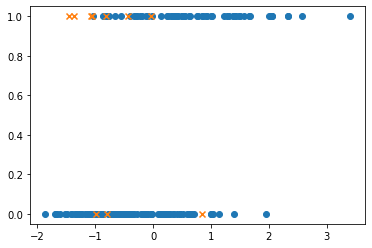

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_test_standard[y_test==y_pred]['smoothness_worst'], y_pred[y_test==y_pred])
ax1.scatter(X_test_standard[y_test!=y_pred]['smoothness_worst'], y_pred[y_test!=y_pred], marker = 'x')
plt.show()

In [27]:
confusion_matrix(y_test, y_pred)

array([[93,  7],
       [ 3, 64]], dtype=int64)

We have no Type II errors now, but we unfortunately in doing so we gain 10 false positives. 

## <u> ElasticNet Regularised Logistic Regression <u>

Let us train an Elastic net logistic regression model on only a subset of the data frame, with the reduced dimension data frame from the Principal Components of the data instead.

In [28]:
EN_log_reg_clf = LogisticRegressionCV(cv = 5, penalty = 'elasticnet', solver = 'saga', l1_ratios = [0.5], max_iter = 10000)
EN_log_reg_clf.fit(X_train_standard, y_train)

print('Training accuracy:', EN_log_reg_clf.score(X_train_standard, y_train))
print('Test accuracy:', EN_log_reg_clf.score(X_test_standard, y_test))

Training accuracy: 0.9922879177377892
Test accuracy: 0.9640718562874252


In [29]:
y_pred = EN_log_reg_clf.predict(X_test_standard)
confusion_matrix(y_test, y_pred)

array([[98,  2],
       [ 4, 63]], dtype=int64)

In [30]:
roc_auc_score(y_test, y_pred)

0.9601492537313433

## <u> Support Vector Machines with RBF kernel <u> ## 

Now for suppor vector machines with a Radial Basis Function kernel. We use a grid search cross validation to optimise the $C$ hyperparameter. 

In [31]:
svm = SVC(kernel='rbf')
parameters = {'C':[1, 10, 100]}
svm_clf_tuned = GridSearchCV(svm, parameters)
svm_clf_tuned.fit(X_train_standard, y_train)
print('Training accuracy:', svm_clf_tuned.score(X_train_standard, y_train))
print('Test accuracy:', svm_clf_tuned.score(X_test_standard, y_test))

Training accuracy: 0.9948586118251928
Test accuracy: 0.9700598802395209


In [32]:
y_pred = svm_clf_tuned.predict(X_test_standard)
confusion_matrix(y_test, y_pred)

array([[100,   0],
       [  5,  62]], dtype=int64)

In [33]:
roc_auc_score(y_test, y_pred)

0.9626865671641791

## <u> Feature Importance Analysis with Random Forest Classifier <u>

We now employ the use of ensemble Random Forest Classifier with Gini impurity as our measure of impurity. We are able to use the full data set despite the collinearity of features, however, we will compare the feature importance result with the Generalised Linear Model section. Hence, we use the same subset as in that section. 

In [34]:
X_train_standard2 = X_train_standard[[ 'texture_mean' , 'smoothness_mean' , 'symmetry_mean' , 'fractal_dimension_mean', 'area_mean', 
                     'concavity_mean']]
X_test_standard2 = X_test_standard[[ 'texture_mean' , 'smoothness_mean' , 'symmetry_mean' , 'fractal_dimension_mean', 'area_mean', 
                     'concavity_mean']]
rand_forest_clf = RandomForestClassifier(criterion = 'gini')
rand_forest_clf.fit(X_train_standard2, y_train)
print('Training accuracy:', rand_forest_clf.score(X_train_standard2, y_train))
print('Test accuracy:', rand_forest_clf.score(X_test_standard2, y_test))

Training accuracy: 1.0
Test accuracy: 0.9580838323353293


The Random Forest classifier perfectly fits the training data. However, it comparatively performs much worse compared to previous classifiers on the test set. This is characteristic of model overfitting. We should look in to pruning or reducing the depth of our trees.

In [35]:
y_pred = rand_forest_clf.predict(X_test_standard2)
confusion_matrix(y_test, y_pred)

array([[99,  1],
       [ 6, 61]], dtype=int64)

In [36]:
roc_auc_score(y_test, y_pred)

0.9502238805970149

In [37]:
feature_importance = dict(zip(X_train_standard2.columns, rand_forest_clf.feature_importances_))
sorted_feature_importance = sorted(feature_importance, key=feature_importance.get, reverse=True)
for i in sorted_feature_importance:
    print(i,':',feature_importance[i])

area_mean : 0.4384478996907181
concavity_mean : 0.26469322828664676
texture_mean : 0.12692718794854035
smoothness_mean : 0.06415951304735988
symmetry_mean : 0.05683235900320645
fractal_dimension_mean : 0.048939812023528415


We observe that 'fractal_dimension_mean' and 'symmetry_mean' are the least important features according to this analysis based on gini impurity. We note here the agreement with the parameter Wald Tests performed earlier! 